# TM10007 Assignment template

In [1]:
# Run this to use from colab environment
!pip install -q --upgrade git+https://github.com/jveenland/tm10007_ml.git

  Preparing metadata (setup.py) ... done


# Importing packages

In [2]:
# General packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets as ds
import seaborn

# Classifiers
from sklearn import model_selection
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm

# Scoring methods
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report

# Preprocessing steps
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from scipy.stats import shapiro
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler

# Feature selection
from sklearn.feature_selection import SelectKBest, f_classif, VarianceThreshold
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn import decomposition

# Data loading and cleaning

Below are functions to load the dataset of your choice. After that, it is all up to you to create and evaluate a classification method. Beware, there may be missing values in these datasets. Good luck!

In [3]:
## Data loading functions. Uncomment the one you want to use
from worclipo.load_data import load_data

data = load_data()
print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')





The number of samples: 115
The number of columns: 494


## Creating a split in the data

A training and test set are created. The training set will be used to fit the classifier, while the test set is remained untouched until it is used for testing the trained classifier.

Split is stratified so labels are present in both sets in same proportions.

In [4]:
# Extract columns with labels
Y = data.pop('label').replace({'lipoma':0, 'liposarcoma':1}) #moeten we misschien nog ook de ID poppen?
print(f'The proportion of the labels is: {sum(Y)/len(Y)}')

# Extract the rest of the data (without the labels)
X = data
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, test_size=0.2, stratify=Y)

print(f'Size of training set: {X_train.shape}')
print(f'Size of test set: {X_test.shape}')

The proportion of the labels is: 0.5043478260869565
Size of training set: (92, 493)
Size of test set: (23, 493)


## Inspecting distribution of features
To determine data distribution of train set

### Visually inspect distribution of features

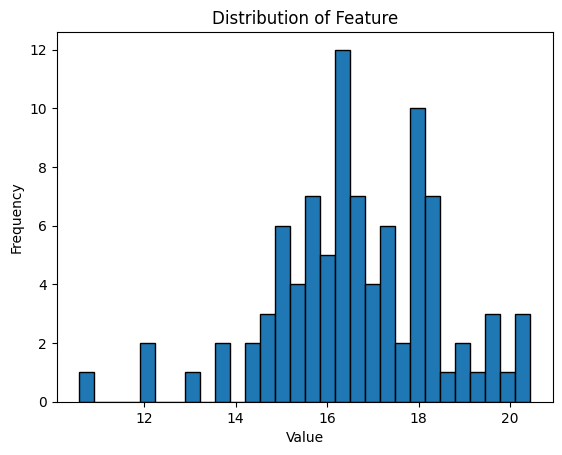

In [5]:
## UITEINDELIJK WEGHALEN DIT!!

#Check if Gaussian distribution per column
# if Gaussian distribution, take mean for filling empty cells (later in script)
# if not Gaussion distribution (and outliers or skewed), take median for filling empty cells (later in script)

# plt.hist(X_train.iloc[:, 15], bins=30, edgecolor='k') # Change number of colum to see distribution (between width dataframe)
plt.hist(X_train['PREDICT_original_tf_Gabor_entropy_F0.2_A1.57'], bins=30, edgecolor='k') # Change number of colum to see distribution (between width dataframe)


plt.title('Distribution of Feature')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

# print(X_train.head())

## Preprocessing Data

### Missing Values
Determining cells with missing values and filling these

In [6]:
# Filling missing values with correct value based on type of distribution per column

# Definieer alpha voor de significantietest BEARGUMENTEREN WAAROM DEZE TEST IN REPORT + WAARDE
alpha = 0.05

# Initialiseer een teller voor normaal verdeelde kolommen
normal_distributed_columns_count = 0
not_normal_distributed_columns_count = 0
nans_found_in_column_count = 0

# Loop door elke kolom in de DataFrame en voer Shapiro-Wilk test uit
for column in X_train:
    stat, p = shapiro(X_train[column])
    if p > alpha:
        # print(column)
        normal_distributed_columns_count += 1  # Tel kolom als normaal verdeeld
        if X_train[column].isna().sum() > 0:
            X_train[column].fillna(X_train[column].mean)
            nans_found_in_column_count += 1
    else:
        not_normal_distributed_columns_count += 1  # Tel kolom als normaal verdeeld
        if X_train[column].isna().sum() > 0:
            X_train[column].fillna(X_train[column].median)
            nans_found_in_column_count += 1

print(f'The number of normal distributed columns is: {normal_distributed_columns_count}')
print(f'The number of not normal distributed columns is: {not_normal_distributed_columns_count}')
print(f'The number of columns where nans were filled: {nans_found_in_column_count}')

/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1879: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "


The number of normal distributed columns is: 74
The number of not normal distributed columns is: 419
The number of columns where nans were filled: 0


### Feature Scaling
Scale features in Train set

#### Motivation of chosen scaler

In [7]:
# Define counter for columns with many outliers
columns_with_many_outliers_count = 0

for column in X_train:
    Q1 = X_train[column].quantile(0.25)
    Q3 = X_train[column].quantile(0.75)
    IQR = Q3 - Q1

    # Calculate number of outliers
    outliers = X_train[(X_train[column] < (Q1 - 1.5 * IQR)) | (X_train[column] > (Q3 + 1.5 * IQR))]
    outliers_count = outliers.shape[0]

    # Define what 'many' outliers mean
    if outliers_count > 0.05 * X_train.shape[0]:
        columns_with_many_outliers_count += 1
        # print(f"{column} has many outliers: {outliers_count} outliers")

print(f"Number of columns with many outliers: {columns_with_many_outliers_count}/{len(X_train.columns)}")


Number of columns with many outliers: 203/493


#### Scaling the data

In [8]:
# Initialize a RobustScaler object
scaler = RobustScaler()

# Fit the scaler on the training data
scaler.fit(X_train)

# Transform both training and testing data using the scaler
X_train_sc = (scaler.transform(X_train))
X_test_sc = scaler.transform(X_test)

X_train_sc = pd.DataFrame(X_train_sc)
X_test_sc = pd.DataFrame(X_test_sc)

# Inspecting data

### Feature selection and extraction

In [9]:
# Zero variance
selector = VarianceThreshold(threshold=0)
vs_fit = selector.fit(X_train_sc)

X_train_zv = vs_fit.transform(X_train_sc)
X_test_zv = vs_fit.transform(X_test_sc)

# Willen we dit nou van train of test set weten?
print(f'Amount of features with zero variance: {X_train_sc.shape[1]-X_train_zv.shape[1]}')
print(f'Amount of features after removing features with zero variance: {X_train_zv.shape[1]}')

Amount of features with zero variance: 19
Amount of features after removing features with zero variance: 474


In [10]:
# Feature selection using K best - chi squared test
fs_chi = SelectKBest(f_classif, k=5).fit(X_train_zv, Y_train)

X_train_fs = fs_chi.transform(X_train_zv)
X_test_fs = fs_chi.transform(X_test_zv)

print(X_train_fs.shape)
print(X_test_fs.shape)


(92, 5)
(23, 5)


In [11]:
# # PCA
# # If there are more samples than features left after RFECV then perform PCA
# pca = decomposition.PCA(n_components=0.95)
# pca.fit(X_train_zv)
# X_train_fs = pca.transform(X_train_zv)
# X_test_fs = pca.transform(X_test_zv)

# Classifiers

In [135]:
# General variables for classifiers
cv = 5

### KNN

In [136]:
knn_model = KNeighborsClassifier()

# Define the parameter grid
param_grid_knn = {
    'n_neighbors': list(range(1, 60, 2)),
    'weights': ['uniform', 'distance'],
    'p': [1, 2]  # p=1 for Manhattan distance, p=2 for Euclidean distance
}

# Create the grid search object with ROC AUC scoring
grid_search_knn = GridSearchCV(knn_model, param_grid_knn, cv=cv, scoring='roc_auc')

# Fit the grid search to the data
grid_search_knn.fit(X_train_fs, Y_train)

# Print the best parameters
print("Best parameters found: ", grid_search_knn.best_params_)

# Get the best estimator
best_knn_model = grid_search_knn.best_estimator_
print(f'Best estimator: {best_knn_model}')

# See how well model works on train data:
pred_knn_train = best_knn_model.predict(X_train_fs)
pred_proba_knn_train = best_knn_model.predict_proba(X_train_fs)[:,1]

roc_auc_knn_train = roc_auc_score(Y_train, pred_proba_knn_train)
print('ROC AUC train=', roc_auc_knn_train)
accuracy_knn_train = accuracy_score(Y_train, pred_knn_train)
print('Accuracy train=', accuracy_knn_train)

# See how well model works on test data:
pred_knn_test = best_knn_model.predict(X_test_fs)
pred_proba_knn_test = best_knn_model.predict_proba(X_test_fs)[:,1]

roc_auc_knn_test = roc_auc_score(Y_test, pred_proba_knn_test)
print('ROC AUC test=', roc_auc_knn_test)
accuracy_knn_test = accuracy_score(Y_test, pred_knn_test)
print('Accuracy test=', accuracy_knn_test)

Best parameters found:  {'n_neighbors': 45, 'p': 2, 'weights': 'uniform'}
Best estimator: KNeighborsClassifier(n_neighbors=45)
ROC AUC train= 0.830812854442344
Accuracy train= 0.717391304347826
ROC AUC test= 0.7462121212121212
Accuracy test= 0.6086956521739131


### Random forest

In [137]:
RF_model = RandomForestClassifier()

# Define the parameter grid
param_grid_RF = {
    'n_estimators': list(range(1, 100, 10)),
    'bootstrap': [True, False],
    'min_samples_leaf': list(range(1, 7, 2))
}

# Create the grid search object with ROC AUC scoring
grid_search_RF = GridSearchCV(RF_model, param_grid_RF, cv=cv, scoring='roc_auc', error_score='raise')

# Fit the grid search to the data
grid_search_RF.fit(X_train_fs, Y_train)

# Print the best parameters
print("Best parameters found: ", grid_search_RF.best_params_)

# Get the best estimator
best_RF_model = grid_search_RF.best_estimator_
print(best_RF_model)

# See how well model works on train data:
pred_RF_train = best_RF_model.predict(X_train_fs)
pred_proba_RF_train = best_RF_model.predict_proba(X_train_fs)[:,1]

roc_auc_RF_train = roc_auc_score(Y_train, pred_proba_RF_train)
print('ROC AUC train=', roc_auc_RF_train)
accuracy_RF_train = accuracy_score(Y_train, pred_RF_train)
print('Accuracy train=', accuracy_RF_train)

# See how well model works on test data:
pred_RF_test = best_RF_model.predict(X_test_fs)
pred_proba_RF_test = best_RF_model.predict_proba(X_test_fs)[:,1]

roc_auc_RF_test = roc_auc_score(Y_test, pred_proba_RF_test)
print('ROC AUC test=', roc_auc_RF_test)
accuracy_RF_test = accuracy_score(Y_test, pred_RF_test)
print('Accuracy test=', accuracy_RF_test)

Best parameters found:  {'bootstrap': True, 'min_samples_leaf': 5, 'n_estimators': 21}
RandomForestClassifier(min_samples_leaf=5, n_estimators=21)
ROC AUC train= 0.9569943289224953
Accuracy train= 0.9021739130434783
ROC AUC test= 0.7575757575757576
Accuracy test= 0.6956521739130435


### Support Vector Machine

In [138]:
# Define the SVM model
svm_model = svm.SVC(probability=True)

# Define the parameter grid for SVM
param_grid_svm = {
    'C': [0.001, 0.01, 0.1, 1, 10],  # Regularization parameter
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1]  # Kernel coefficient
}

# Create the grid search object with ROC AUC scoring
grid_search_svm = GridSearchCV(svm_model, param_grid_svm, cv=cv, scoring='roc_auc', error_score='raise')

# Fit the grid search to the data
grid_search_svm.fit(X_train_fs, Y_train)

# Print the best parameters
print("Best parameters found: ", grid_search_svm.best_params_)

# Get the best estimator
best_svm_model = grid_search_svm.best_estimator_
print(best_svm_model)

# See how well model works on train data
pred_svm_train = best_svm_model.predict(X_train_fs)
pred_proba_svm_train = best_svm_model.decision_function(X_train_fs)

roc_auc_svm_train = roc_auc_score(Y_train, pred_proba_svm_train)
print('ROC AUC train=', roc_auc_svm_train)
accuracy_svm_train = accuracy_score(Y_train, pred_svm_train)
print('Accuracy train=', accuracy_svm_train)

# See how well model works on test data
pred_svm_test = best_svm_model.predict(X_test_fs)
pred_proba_svm_test = best_svm_model.decision_function(X_test_fs)

roc_auc_svm_test = roc_auc_score(Y_test, pred_proba_svm_test)
print('ROC AUC test=', roc_auc_svm_test)
accuracy_svm_test = accuracy_score(Y_test, pred_svm_test)
print('Accuracy test=', accuracy_svm_test)

Best parameters found:  {'C': 0.1, 'gamma': 0.1}
SVC(C=0.1, gamma=0.1, probability=True)
ROC AUC train= 0.8501890359168242
Accuracy train= 0.7391304347826086
ROC AUC test= 0.6363636363636364
Accuracy test= 0.5652173913043478


## Visualisatie

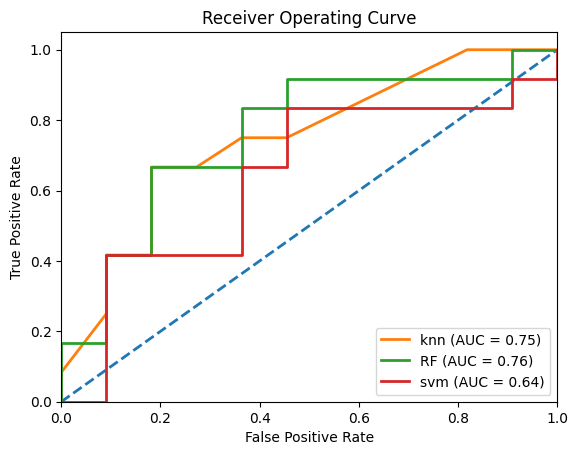

In [139]:
from sklearn.metrics import roc_curve, auc

# Plot the ROC curve of the different classifiers
plt.figure()
lw = 2
plt.plot([0, 1], [0, 1], lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Curve')

# knn
fpr_knn, tpr_knn, _ = roc_curve(Y_test, pred_proba_knn_test)
roc_auc_knn = auc(fpr_knn, tpr_knn)
plt.plot(fpr_knn, tpr_knn, lw=lw, label='knn (AUC = %0.2f)' % roc_auc_knn)

# RF
fpr_RF, tpr_RF, _ = roc_curve(Y_test, pred_proba_RF_test)
roc_auc_RF = auc(fpr_RF, tpr_RF)
plt.plot(fpr_RF, tpr_RF, lw=lw, label='RF (AUC = %0.2f)' % roc_auc_RF)

# svm
fpr_svm, tpr_svm, _ = roc_curve(Y_test, pred_proba_svm_test)
roc_auc_svm = auc(fpr_svm, tpr_svm)
plt.plot(fpr_svm, tpr_svm, lw=lw, label='svm (AUC = %0.2f)' % roc_auc_svm)

plt.legend(loc="lower right")
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 444, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 668, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py", line 234, in predict
    neigh_ind = self.kneighbors(X, return_distance=False)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py", line 810, in kneighbors
    raise ValueError(
Val

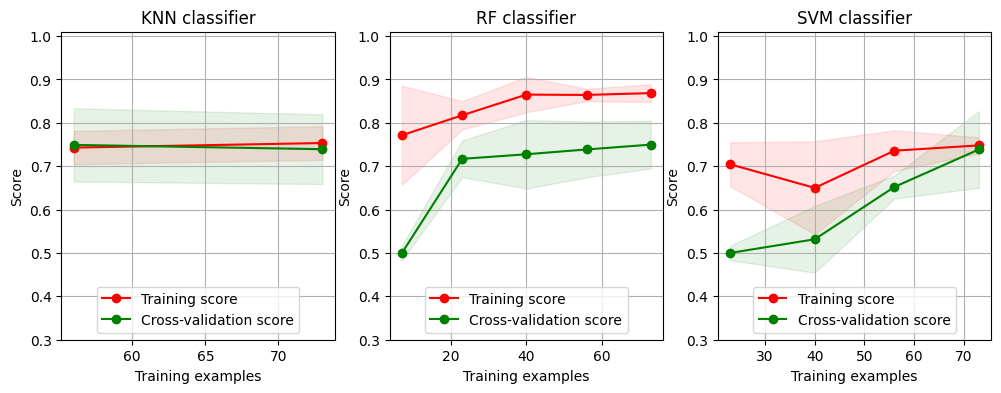

In [140]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, title, X, Y, axes, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    axes : array of 3 axes, optional (default=None)
        Axes to use for plotting the curves.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """

    axes.set_title(title)
    if ylim is not None:
        axes.set_ylim(*ylim)
    axes.set_xlabel("Training examples")
    axes.set_ylabel("Score")

    train_sizes, train_scores, test_scores  = \
        learning_curve(estimator, X, Y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plot learning curve
    axes.grid()
    axes.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes.plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes.plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes.legend(loc="lower center")

    return plt

clsfs = {
    'KNN classifier': best_knn_model,
    'RF classifier': best_RF_model,
    'SVM classifier': best_svm_model
}

fig = plt.figure(figsize=(12,4))
num=0

for name, clf in clsfs.items():
    ax = fig.add_subplot(1, 3, num + 1)
    plot_learning_curve(clf, name, X_train_fs, Y_train, ax, ylim=(0.3, 1.01), cv=cv)
    num += 1